# Introdução ao PyTorch


[PyTorch](http://pytorch.org/) é um framework para desenolver e treinar redes neurais. Muitas de suas funções se comportam exatamente da mesma forma que o numpy, onde os arrays são chamados de tensores. A vantagem desses tensores em relação aos arrays do numpy é que eles facilitam a movimentação dos dados da CPU para a GPU, e também são usados por funções do PyTorch para computar altomaticamente gradientes (para o backpropagation) e outros modulos para construir redes neurais. No geral, PyTorch é mais coerente com programação Python e Numpy/Scipy quando comparada com TensorFlow ou outros frameworks.


Como vimos na Regressão Linear, Regressão Logística e Perceptron, uma coisa muito comum na área de aprendizado de máquinas é resolver equações lineares do tipo:

$$
\begin{align}
y &= f(w_1 x_1 + w_2 x_2 + b) \\
y &= f\left(\sum_i w_i x_i +b \right)
\end{align}
$$

Em forma de vetores, podemos representar o produto escalar:

$$
h = \begin{bmatrix}
x_1 \, x_2 \cdots  x_n
\end{bmatrix}
\cdot 
\begin{bmatrix}
           w_1 \\
           w_2 \\
           \vdots \\
           w_n
\end{bmatrix}
$$

## Tensores

A grosso modo, algoritmos de aprendizado envolvem diversas operações de álgebra linear em tensores, uma generalização de matrizes. Um vetor é um tensor de 1 dimensão, e uma matriz é um tensor de 2 dimensões, e um array com 3 dimensões é um tensor tridimensional (para imagens RGB, por exemplo). Sendo assim, a estrutura fundamental de redes neurais e PyTorch são os tensores.


<img src="assets/tensor_examples.svg" width=600px>

Vejamos alguns exemplos de uso do PyTorch e seus tensores

In [ ]:
# Primeiramente, importamos o PyTorch
import torch

In [ ]:
def activation(x):
    """ Função de ativação - Sigmoid
    
        Argumentos
        ---------
        x: torch.Tensor
    """
    return 1/(1+torch.exp(-x))

In [ ]:
### Gerando dados aleatórios
torch.manual_seed(7) # Seta um seed para sempre gerar os mesmos números aleatórios

# Features é um tensor com 1 linha (1 única amostra) e 5 colunas (5 características por amostra), 
#   inicializadas de forma aleatória usando uma distribuição normal com média zero e desvio 1.
features = torch.randn((1, 5))

# Gerando os pesos aleatórios para o nosso modelo. randn_like gera um tensor com as mesmas carácterísticas
#    que o tensor passado como parâmetro
weights = torch.randn_like(features)
# ou :
weights = torch.Tensor(torch.randn((1,5)))


# termo de bias - tensor com uma única linha e coluna.
bias = torch.randn((1, 1))

Esses tensores podem ser somados, subtraidos, multiplicados, etc, assim como os arrays numpy. Em geral, usamos os tensores de forma bem parecida com esses arrays, com a vantagem de poder utilizar em GPUs. Como exemplo, podemos computar a saída desse nosso modelo de neurônio:

In [ ]:
# Podemos predizer a saída do nosso neurônio:

# Assim como numpy, podemos usar as opções torch.sum(), assim como o métodos .sum() nos tensores.

# opção 1 - torch.sum()
y = activation(torch.sum(features * weights) + bias)
print('opção 1: ', y)

# opção 2 - .sum()
y = activation((features * weights).sum() + bias)
print('opção 2: ', y)

# Podemos também juntar as operações de soma e multiplicação numa única operação, executando a multiplicação
#   de matrizes. Em geral, multiplicação de matriz é mais eficiente, principalmente em GPUs. 
#   Para tanto, podemos utilizar as funções torch.mm() ou torch.matmul() - a última é mais complexa
#      e oferece mais opções (verificar em https://pytorch.org/docs/stable/generated/torch.matmul.html).

# opção 3 - torch.mm()
#y = activation(torch.mm(features, weights.view(5,1)) + bias)
y = activation(torch.mm(features, weights.T) + bias)
#y = activation(torch.mm(weights, features.T) + bias)
print('opção 3: ', y)

opção 1:  tensor([[0.9741]])
opção 2:  tensor([[0.9741]])
opção 3:  tensor([[0.9741]])


Note que na opção 3 tivemos que redimensionar nosso vetor de pesos com a função .view(). Caso contrário, teríamos um erro muito comum:

In [ ]:
#torch.mm(features, weights)

Isso por que, na multiplicação de matrizes, o número de colunas no primeiro tensor deve ser igual ao número de linhas do segundo tensor. Tanto o tensor features quanto o tensor weights tem o mesmo formato, i.e., (1,5). Sendo assim, foi necessário mudar o formato para que a multiplicação funcionasse.

Obs: para ver o formato de um tensor, podemos simplesmente usar .shape.

Existem também algumas opções para mudar o formato do tensor: [`.reshape()`](https://pytorch.org/docs/stable/generated/torch.reshape.html#torch.reshape), [`.resize_()`](https://pytorch.org/docs/stable/generated/torch.Tensor.resize_.html#torch.Tensor.resize_) e [`.view()`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html#torch.Tensor.view).

Usando como exemplo nosso tensor weights:

* `weights.reshape(a, b)` retorna um novo tensor com os mesmos dados de `weights` com tamanho `(a, b)`, quando possível retorna apenas um view(), quando não, faz uma cópia dos dados.

* `weights.resize_(a, b)` retorna o mesmo tensor com um formato diferente. Se o número de elementos for menor que o original, alguns elementos serão removidos do tensor (mas não da memória). Se o novo formato tem mais elementos, estes serão inicializados na memória. Note que o _ quer dizer que as operações são executadas **in-place**. [Clique aqui para mais informações a respeito](https://discuss.pytorch.org/t/what-is-in-place-operation/16244).

* `weights.view(a, b)` retorna um tensor  no formato `(a, b)` com os mesmos dados contidos em `weights`.



## Regressão Logística

<img src="assets/regLog.png" width=400px>

In [1]:
# importando pacotes

import tqdm
import torch
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
from matplotlib import pyplot as plt
import torchvision

## Carregando o dataset

Usamos torchvision.datasets para carregar o dataset Fashion-MNIST. Transforms são ferramentas de normalização, aumento de dados, entre outros. Nesse caso utilizaremos apenas para transformar em vetor.

In [3]:
train_dataset = dsets.KMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.KMNIST(root='./data', train=False, transform=transforms.ToTensor())


  0%|          | 0/18165135 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/29497 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/3041136 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



  0%|          | 0/5120 [00:00<?, ?it/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



## Criando um data loader

Conjuntos de dados grandes não podem ser carregados diretamente na memória, principalmente da GPU, por falta de espaço. Para isso, utilizamos data loaders, para carregar _batches_, ou seja, porções de amostras, a cada chamada.

In [4]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


## Criando o modelo

In [5]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

## Definindo os hyperparâmetros e instanciando o modelo

In [6]:
epochs = 10
input_dim = 784
output_dim = 10
lr_rate = 0.001

model = LogisticRegression(input_dim, output_dim)

## Instanciando a classe de Loss

Em seguida definimos nossa função de loss, no caso a entropia cruzada (Cross-Entropy (CE)). Note que CE é praticamente a função Maximum Likelihood Estimation (MLE) que aprendemos na aula passada, com sinal inverso, ou seja, minimizar o BCE é praticamente a mesma coisa que maximizar o MLE.

In [7]:
criterion = torch.nn.CrossEntropyLoss() # computes softmax and then the cross entropy

## Definindo o otimizador

In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

## Treinando o modelo

In [9]:
for epoch in range(epochs):
    sum_loss = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28 * 28)
        labels = labels

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)        
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()

    # calcula acurácia no teste
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.view(-1, 28*28)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total+= labels.size(0)
        # for gpu, bring the predicted and labels back to cpu fro python operations to work
        correct+= (predicted == labels).sum()
    accuracy = 100 * correct.float()/total
    print("Epoch: {}. Loss: {}. Accuracy: {}.".format(epoch+1, np.round(sum_loss/i,3), np.round(accuracy,3)))

Epoch: 1. Loss: 0.833. Accuracy: 67.80000305175781.
Epoch: 2. Loss: 0.628. Accuracy: 69.20999908447266.
Epoch: 3. Loss: 0.603. Accuracy: 69.7300033569336.
Epoch: 4. Loss: 0.591. Accuracy: 70.44999694824219.
Epoch: 5. Loss: 0.582. Accuracy: 69.88999938964844.
Epoch: 6. Loss: 0.577. Accuracy: 70.37999725341797.
Epoch: 7. Loss: 0.572. Accuracy: 70.16999816894531.
Epoch: 8. Loss: 0.568. Accuracy: 70.19000244140625.
Epoch: 9. Loss: 0.565. Accuracy: 70.04000091552734.
Epoch: 10. Loss: 0.563. Accuracy: 70.26000213623047.


In [10]:
test_loader

In [11]:
len(outputs)

100

In [12]:
predicted

tensor([0, 2, 8, 6, 8, 1, 1, 7, 0, 2, 0, 2, 2, 5, 5, 4, 9, 4, 7, 6, 2, 9, 0, 0,
        4, 5, 8, 8, 2, 6, 2, 5, 0, 5, 7, 7, 4, 5, 3, 8, 0, 4, 4, 6, 3, 6, 6, 7,
        2, 1, 3, 5, 1, 8, 9, 6, 2, 9, 3, 6, 0, 0, 8, 7, 0, 3, 3, 7, 2, 6, 7, 7,
        5, 2, 4, 7, 3, 9, 2, 1, 5, 3, 1, 3, 0, 1, 5, 7, 8, 9, 8, 4, 7, 6, 0, 9,
        0, 9, 8, 6])

## Exercícios

1. Plotar algumas imagens do dataset fashion MNIST para ter uma idea de como são as amostras.


2. Estimar os rótulos das amostras de teste, computar a acurácia e gerar uma matriz de confusão para ver com quais classes cada classe está se confundindo
3. Rodar esse algoritmo utilizando o dataset Kuzushiji-MNIST (KMNIST). Pesquisar para fazer aumento de dados (transform) com horizontal flipping. Plotar algumas imagens desse dataset também. 

Tentativa 99

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

8


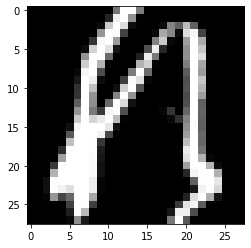

In [15]:
image, label = next(iter(train_dataset))
plt.imshow(image.squeeze(), cmap="gray")
print(label)

In [16]:
demo_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([100, 1, 28, 28]) torch.Size([100])


labels:  

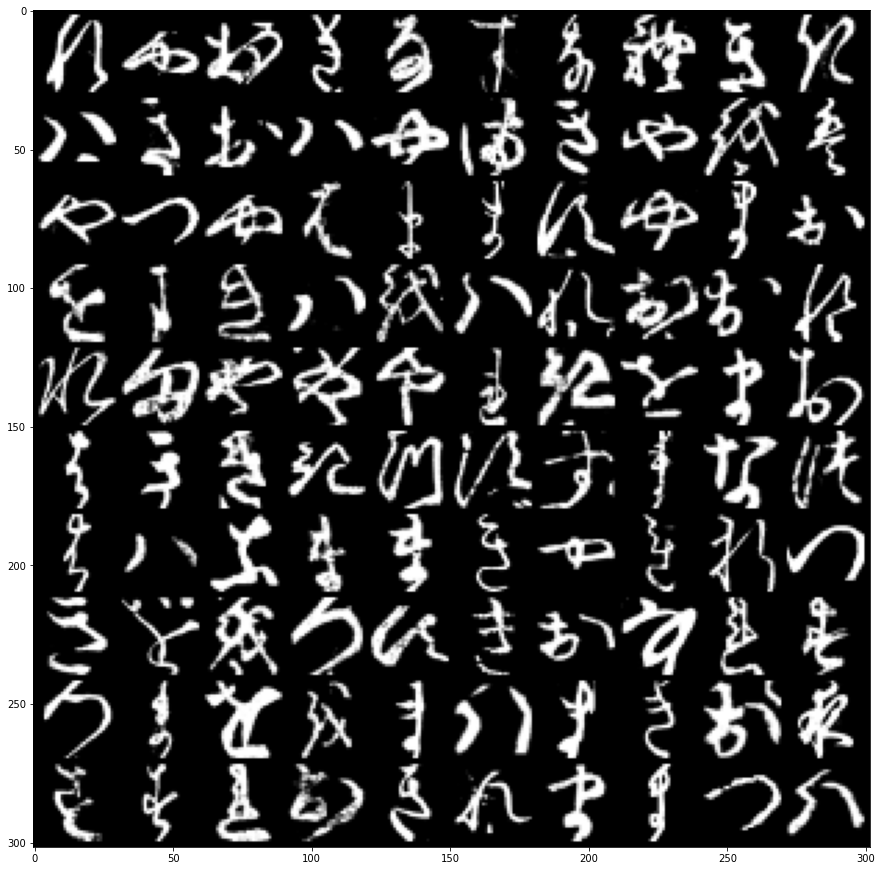

In [17]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")


In [18]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [19]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [20]:
num_epochs = 10
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        # Transfering images and labels to GPU if available
        images, labels = images.to(device), labels.to(device)
    
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)
        
        # Forward pass 
        outputs = model(train)
        loss = error(outputs, labels)
        
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        loss.backward()
        
        # Optimizing the parameters
        optimizer.step()
    
        count += 1
    
    # Testing the model
    
        if not (count % 50):    # It's same as "if count % 50 == 0"
            total = 0
            correct = 0
        
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
            
                test = Variable(images.view(100, 1, 28, 28))
            
                outputs = model(test)
            
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
            
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.1238357424736023, Accuracy: 87.30000305175781%
Iteration: 1000, Loss: 0.16740664839744568, Accuracy: 91.0%
Iteration: 1500, Loss: 0.15763209760189056, Accuracy: 90.87999725341797%
Iteration: 2000, Loss: 0.1080758199095726, Accuracy: 91.58000183105469%
Iteration: 2500, Loss: 0.06011221930384636, Accuracy: 91.16000366210938%
Iteration: 3000, Loss: 0.03653724491596222, Accuracy: 92.87999725341797%
Iteration: 3500, Loss: 0.26140013337135315, Accuracy: 92.30000305175781%
Iteration: 4000, Loss: 0.015031162649393082, Accuracy: 93.80000305175781%
Iteration: 4500, Loss: 0.012000717222690582, Accuracy: 92.48999786376953%
Iteration: 5000, Loss: 0.02702152542769909, Accuracy: 93.30000305175781%
Iteration: 5500, Loss: 0.0008968362235464156, Accuracy: 93.38999938964844%
Iteration: 6000, Loss: 0.016045115888118744, Accuracy: 93.41000366210938%


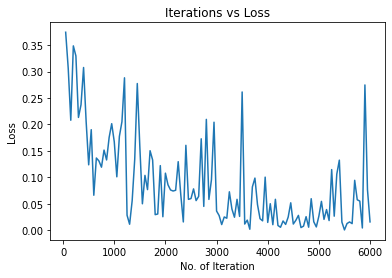

In [21]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

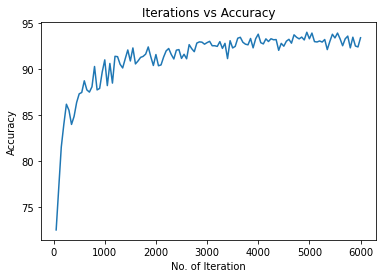

In [22]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [23]:
from itertools import chain 

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [24]:
import sklearn.metrics as metrics

cm = confusion_matrix(labels_l, predictions_l)
print("Classification report for CNN :\n%s\n"
      % (metrics.classification_report(labels_l, predictions_l)))

Classification report for CNN :
              precision    recall  f1-score   support

           0       0.93      0.92      0.93    120000
           1       0.91      0.92      0.91    120000
           2       0.87      0.85      0.86    120000
           3       0.91      0.95      0.93    120000
           4       0.91      0.88      0.90    120000
           5       0.93      0.90      0.92    120000
           6       0.89      0.93      0.91    120000
           7       0.92      0.91      0.91    120000
           8       0.93      0.94      0.93    120000
           9       0.93      0.93      0.93    120000

    accuracy                           0.91   1200000
   macro avg       0.91      0.91      0.91   1200000
weighted avg       0.91      0.91      0.91   1200000




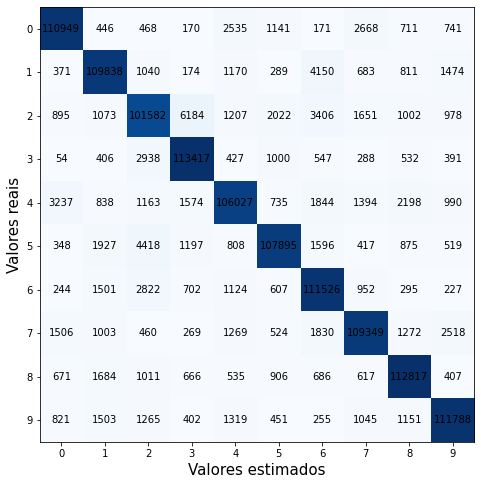

In [25]:
# plotando a matriz

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm, cmap=plt.cm.Blues)
ax.grid(False)
ax.set_xlabel('Valores estimados', fontsize=15, color='black')
ax.set_ylabel('Valores reais', fontsize=15, color='black')
ax.xaxis.set(ticks=range(10))
ax.yaxis.set(ticks=range(10))
ax.set_ylim(9.5, -0.5)
for i in range(10):
    for j in range(10):
        ax.text(j, i, cm[i, j], ha='center', va='center')
plt.show()